### Load and clean

In [41]:
import pandas as pd
import re
import string

# Load cleaned threads
threads_df = pd.read_csv("../data/processed/threads_clean.csv")

# Clean function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"@\w+", '', text)                     # remove mentions
    text = re.sub(r"[^\w\s]", '', text)                  # remove punctuation
    text = re.sub(r"\s+", ' ', text).strip()             # remove extra spaces
    return text

# Apply cleaning
threads_df['clean_question'] = threads_df['question'].apply(clean_text)

# Preview
threads_df[['question', 'clean_question']].head()

,question,clean_question
0,I have been attempting to display data from a ...,i have been attempting to display data from a ...
1,Migration In Progress: EJS ReactWe're current...,migration in progress ejs reactwere currently ...
2,"Following is my code, it was fine when I looke...",following is my code it was fine when i looked...
3,Hello! My name is Simon I'm a web developer bu...,hello my name is simon im a web developer but ...
4,I think that this code is right.What should I do?,i think that this code is rightwhat should i do


### Tokenization + Stopword Removal

In [24]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Tokenize and remove stopwords
def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    filtered = [w for w in tokens if w not in stop_words and w.isalpha()]
    return filtered

threads_df['tokens'] = threads_df['clean_question'].apply(tokenize_and_filter)

# Preview
threads_df[['clean_question', 'tokens']].head()

,clean_question,tokens
0,i have been attempting to display data from a ...,"[attempting, display, data, certain, index, js..."
1,migration in progress ejs reactwere currently ...,"[migration, progress, ejs, reactwere, currentl..."
2,following is my code it was fine when i looked...,"[following, code, fine, looked, nextelement, e..."
3,hello my name is simon im a web developer but ...,"[hello, name, simon, im, web, developer, ive, ..."
4,i think that this code is rightwhat should i do,"[think, code, rightwhat]"


### One-time setup

In [26]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Lemmatize Tokens

In [43]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

threads_df['lemmas'] = threads_df['tokens'].apply(lemmatize_tokens)

# Preview
threads_df[['tokens', 'lemmas']].head()

,tokens,lemmas
0,"[attempting, display, data, certain, index, js...","[attempting, display, data, certain, index, js..."
1,"[migration, progress, ejs, reactwere, currentl...","[migration, progress, ejs, reactwere, currentl..."
2,"[following, code, fine, looked, nextelement, e...","[following, code, fine, looked, nextelement, e..."
3,"[hello, name, simon, im, web, developer, ive, ...","[hello, name, simon, im, web, developer, ive, ..."
4,"[think, code, rightwhat]","[think, code, rightwhat]"


### TF-IDF Vectorization

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join lemmas for vectorization
threads_df['lemma_text'] = threads_df['lemmas'].apply(lambda tokens: ' '.join(tokens))

# TF-IDF setup
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)  # unigrams + bigrams

# Fit and transform
X_tfidf = tfidf.fit_transform(threads_df['lemma_text'])

# Inspect shape
print("TF-IDF Matrix shape:", X_tfidf.shape)

TF-IDF Matrix shape: (1062, 3000)


## Manual Categorization
### Create the CSV for Labeling

In [45]:
# Create a folder if it doesn't exist
import os
os.makedirs("../data/manual_labels", exist_ok=True)

# Sample 250 representative questions for labeling
label_sample_df = threads_df[['thread_id', 'title', 'question']].sample(250, random_state=42)
label_sample_df['category'] = ''  # Empty column for you to fill in

# Save to CSV
label_sample_df.to_csv("../data/manual_labels/questions_to_label.csv", index=False)
print("File saved to: ../data/manual_labels/questions_to_label.csv")

File saved to: ../data/manual_labels/questions_to_label.csv


### Search for likely Career Advice questions

In [46]:
# Show potential career-related questions
career_keywords = ['career', 'job', 'intern', 'resume', 'interview', 'linkedin']
career_candidates = threads_df[
    threads_df['question'].str.contains('|'.join(career_keywords), case=False, na=False)
][['thread_id', 'title', 'question']]

career_candidates = career_candidates.sample(15, random_state=1)
career_candidates

,thread_id,title,question
393,361,What framework to learn,I want to learn how to make a fullstack websit...
846,823,who can solve this riddle,You have a linked list of objects. Each object...
656,289,HELP me I am lost. (Career Advice),"Hey everyone,I'm 24 years old and recently gra..."
412,297,Sections Hide and Unhide,"Good day,I'm sorry to bother you, but I really..."
23,53,Resume question,Hey everyone I have been making a static websi...
699,406,React Bootstrap Pills problem :',Hi everyone. So I am using React Bootstrap for...
993,195,Need someone willing to teach me,"Hey, I'm new to the boot camp thinking about g..."
827,746,Can't seem to treat an error,This is my catch block:} catch (error) { co...
617,187,Where to go from here?,"Hello programmers, I am looking for general ad..."
725,501,"hi guys, I need some help with deciding betwee...",There is no fast path to learning programming ...


### Search for likely Resource Request questions

In [47]:
# Show potential resource-related questions
resource_keywords = ['resource', 'link', 'site', 'tutorial', 'course', 'docs', 'documentation']
resource_candidates = threads_df[
    threads_df['question'].str.contains('|'.join(resource_keywords), case=False, na=False)
][['thread_id', 'title', 'question']]

resource_candidates = resource_candidates.sample(15, random_state=2)
resource_candidates

,thread_id,title,question
556,19,what learning platform is better?,guys what platform do you recommend for taking...
173,578,How to: mindmap like graph board design in Rea...,"Hello everyone. At where work, I'm asked add a..."
364,172,the mystery of the disappearing text (Or is my...,I'm working on a calculator project [Live link...
68,187,Error when combining NodeJS and HTML,So I was making a simple clicker game. Here is...
480,504,"Product Landing Page - Clipping, overflow, and...",Ive been having some CSS issues on my product ...
605,158,What should I do next? React developer in need...,"I have been self teaching javascript, html, cs..."
398,264,can i use base ui with material ui and system ...,I wanted to use material UI for my next app wi...
74,201,Step 49 Learn Typography by Building a Nutriti...,"<!DOCTYPE html><html lang=""en""><head> <meta ch..."
759,582,why this scroll outlook is not fully functioning?,i am trying to have a dropdown menu using divs...
22,49,Bussiness card problem,"<!DOCTYPE html><html lang=""en""><head> <meta ch..."


### Add Career/Resource Candidates to Labeling CSV

In [48]:
# Add a new column for manual labeling
career_candidates = career_candidates.drop(columns=['label'], errors='ignore')
resource_candidates = resource_candidates.drop(columns=['label'], errors='ignore')
career_candidates['category'] = ''
resource_candidates['category'] = ''

# Load existing questions to label
existing = pd.read_csv("../data/manual_labels/questions_to_label.csv")

# Concatenate
combined = pd.concat([existing, career_candidates, resource_candidates], ignore_index=True)

# Save back
combined.to_csv("../data/manual_labels/questions_to_label.csv", index=False)

### Load and merge labeled data

In [49]:
# Load labeled questions
labels_df = pd.read_csv("../data/manual_labels/questions_to_label.csv")

# Sanity check
print("Labels shape:", labels_df.shape)
labels_df.head()

Labels shape: (280, 4)


,thread_id,title,question,category
0,80.0,Need Assistance for my data selector for my Nu...,"Hello, I'm having issues with the date selecto...",Bug Help
1,298.0,Learn Form Validation - Step 14,"const calorieCounter = getElementById(""calorie...",Code Review
2,668.0,Need help with a project from github,Good afternoon programmers/Devs I just recentl...,Bug Help
3,67.0,Help with Tetris Neural Network,my Tetris AI to compete against user.how does ...,Learning Question
4,664.0,react component purity,The react documentation says that react compon...,Learning Question


In [50]:
# Merge with threads_df to get preprocessed text (lemma_text)
labeled_df = labels_df.merge(threads_df[["thread_id", "lemma_text"]], on="thread_id")

# Final shape check
print("Merged labeled data shape:", labeled_df.shape)
labeled_df[["thread_id", "category", "lemma_text"]].head()

Merged labeled data shape: (522, 5)


,thread_id,category,lemma_text
0,80.0,Bug Help,hello im issue date selector project currently...
1,80.0,Bug Help,hey trying build navbar get issue background c...
2,80.0,Bug Help,attempting host website github page made react...
3,298.0,Code Review,const caloriecounter getelementbyidcaloriecounter
4,668.0,Bug Help,anyone get incorrect asked time forum


### TF-IDF vectorization of lemma_text

In [51]:
# TF-IDF vectorizer setup (same config)
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)

# Fit and transform
X = tfidf.fit_transform(labeled_df["lemma_text"])

# Check shape
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (522, 3000)


### Encode target labels

In [52]:
from sklearn.preprocessing import LabelEncoder

# Label encode the category
le = LabelEncoder()
y = le.fit_transform(labeled_df["category"])

# Show label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'Bug Help': np.int64(0), 'Career Advice': np.int64(1), 'Code Review': np.int64(2), 'General Discussion': np.int64(3), 'Learning Question': np.int64(4), 'Resource Request': np.int64(5)}


### Train/Test Split & Naive Bayes Model

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Split the data (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on test set
y_pred = nb_model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
                     precision    recall  f1-score   support

          Bug Help       0.39      0.83      0.54        36
     Career Advice       0.00      0.00      0.00         8
       Code Review       0.00      0.00      0.00         2
General Discussion       0.38      0.33      0.36        30
 Learning Question       0.00      0.00      0.00        17
  Resource Request       1.00      0.17      0.29        12

          accuracy                           0.40       105
         macro avg       0.30      0.22      0.20       105
      weighted avg       0.36      0.40      0.32       105

Confusion Matrix:
 [[30  0  0  6  0  0]
 [ 6  0  0  2  0  0]
 [ 2  0  0  0  0  0]
 [20  0  0 10  0  0]
 [11  0  0  6  0  0]
 [ 7  0  0  2  1  2]]


c:\Users\MSI\Desktop\PROJECTS\PFA\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MSI\Desktop\PROJECTS\PFA\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MSI\Desktop\PROJECTS\PFA\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

### Train & Evaluate SVM + Random Forest

In [57]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Utility function to train and evaluate models
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    print("Confusion Matrix:\n")
    print(confusion_matrix(y_test, y_pred))

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Evaluate SVM
svm_model = LinearSVC()
evaluate_model("SVM", svm_model, X_train, X_test, y_train, y_test)

# Evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)


SVM Classification Report:

                    precision    recall  f1-score   support

          Bug Help       0.38      0.42      0.40        36
     Career Advice       0.33      0.25      0.29         8
       Code Review       0.00      0.00      0.00         2
General Discussion       0.37      0.50      0.42        30
 Learning Question       0.00      0.00      0.00        17
  Resource Request       0.40      0.33      0.36        12

          accuracy                           0.34       105
         macro avg       0.25      0.25      0.25       105
      weighted avg       0.31      0.34      0.32       105

Confusion Matrix:

[[15  2  0 13  2  4]
 [ 3  2  1  0  2  0]
 [ 2  0  0  0  0  0]
 [ 9  1  0 15  3  2]
 [ 7  1  0  9  0  0]
 [ 3  0  0  4  1  4]]

Random Forest Classification Report:

                    precision    recall  f1-score   support

          Bug Help       0.49      0.56      0.52        36
     Career Advice       0.25      0.25      0.25         8
  

### Category Distribution Visualization

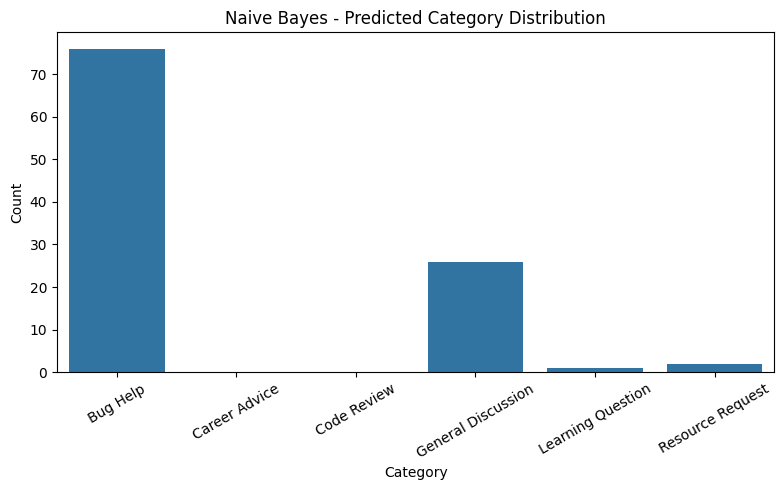

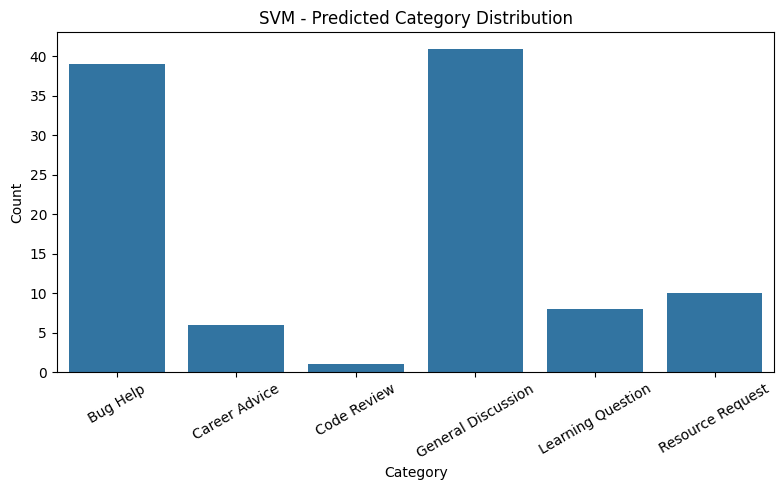

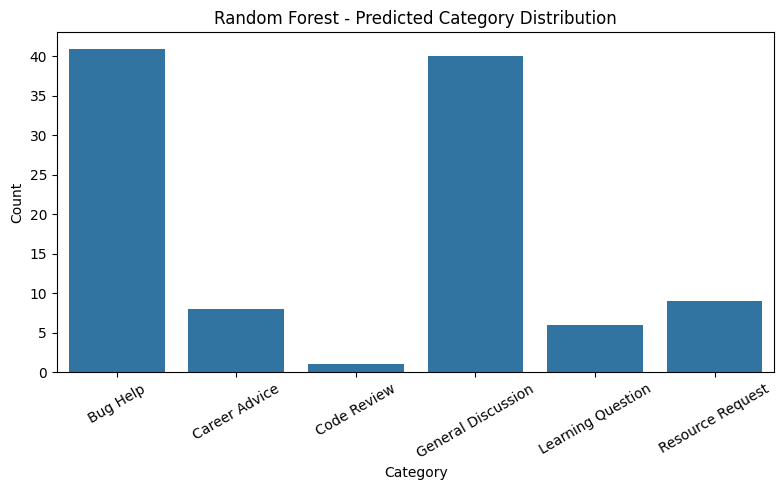

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Store predicted labels for each model
nb_preds = nb_model.predict(X_test)
svm_preds = svm_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Reverse the label encoder to get original category names
def decode_preds(preds): return [le.classes_[i] for i in preds]

# Plotting function
def plot_pred_dist(preds, title):
    decoded = decode_preds(preds)
    plt.figure(figsize=(8, 5))
    sns.countplot(x=decoded, order=le.classes_)
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Plot each model's predictions
plot_pred_dist(nb_preds, "Naive Bayes - Predicted Category Distribution")
plot_pred_dist(svm_preds, "SVM - Predicted Category Distribution")
plot_pred_dist(rf_preds, "Random Forest - Predicted Category Distribution")